### Zooming in on a region and plotting plate boundaries plus US states

Here we explore a combination of geopandas and cartopy functionality

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from datetime import datetime
import cartopy.feature as cfeature
from matplotlib.transforms import offset_copy
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

Get all events in Cascadia

In [2]:
minlon = -132
maxlon = -120
minlat = 38
maxlat = 50

client = Client("IRIS")
starttime = '1980-01-01'
endtime = str(datetime.now()).split()[0]
minmag = 4
quake_catalog = client.get_events(starttime=UTCDateTime(starttime),endtime=UTCDateTime(endtime),\
                            minmagnitude=minmag,minlongitude=minlon,maxlongitude=maxlon,minlatitude=minlat,maxlatitude=maxlat)

In [3]:
def scale_events(events):
    
    '''Function to scale earthquakes so that they look good on a map'''
    
    return 0.1*np.exp(events)

In [4]:
LLD = np.zeros([len(quake_catalog),4])

for i in range(len(quake_catalog)):
    event = quake_catalog[i]
    LLD[i,0] = event.origins[0].longitude
    LLD[i,1] = event.origins[0].latitude
    
    depth = event.origins[0].depth
    if depth == None:
        LLD[i,2] = np.nan
    else:
        LLD[i,2] = depth/1000
        
    LLD[i,3] = event.magnitudes[0].mag

eventdetails = pd.DataFrame(LLD)
eventdetails.columns = ['LON','LAT','DEP','MAG']
eventdetails.dropna(inplace=True )

In [5]:
USstates = gpd.read_file('/Users/rmartinshort/Documents/Berkeley/Python_Maps/us_states/states.shp')

In [6]:
USstates.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


Reproject in whatever projection system works best. Look at http://geopandas.org/projections.html for more details

In [7]:
USstates_reproj = USstates.to_crs(epsg=2163)

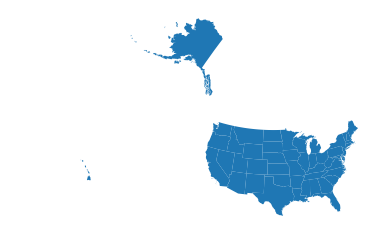

In [8]:
USstates_reproj.plot();
plt.axis('off');

In [9]:
#Note that the projection needs to be lat/lon in order for this to be plotted on the map
oregon = USstates[USstates['STATE_NAME']=='Oregon']
california = USstates[USstates['STATE_NAME']=='California']
washington = USstates[USstates['STATE_NAME']=='Washington']

In [10]:
#plate boundaries
boundaries = gpd.read_file("/Users/rmartinshort/Documents/Berkeley/Python_Maps/tectonicplates-master/GeoJSON/PB2002_boundaries.json")
plates = gpd.read_file("/Users/rmartinshort/Documents/Berkeley/Python_Maps/tectonicplates-master/GeoJSON/PB2002_plates.json")

In [32]:
boundaries.crs

{'init': 'epsg:4326'}

In [23]:
california.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
24,California,25,06,Pacific,CA,(POLYGON ((-121.6652203096974 38.1692853630126...


In [11]:
newplatebounds = gpd.read_file("/Users/rmartinshort/Documents/Berkeley/Python_Maps/plate_bounds/Plate_Boundaries.shp")

In [12]:
newplatebounds.head()

,HAZ_PLATES,HAZ_PLAT_1,HAZ_PLAT_2,Shape_Leng,geometry
0,TRENCH,SERAM TROUGH (ACTIVE),6722,5.843467,LINESTRING (133.6808931800001 -5.4442003619999...
1,TRENCH,WETAR THRUST,6722,1.829013,"LINESTRING (125.478798029 -7.760600482999962, ..."
2,TRENCH,TRENCH WEST OF LUZON (MANILA TRENCH) NORTHERN ...,6621,6.743604,"LINESTRING (120.099997988 19.81789981900005, 1..."
3,TRENCH,BONIN TRENCH,9821,8.329381,LINESTRING (143.2062070010001 26.1758992150000...
4,TRENCH,NEW GUINEA TRENCH,8001,11.998145,LINESTRING (132.8273013480001 0.41880004000006...


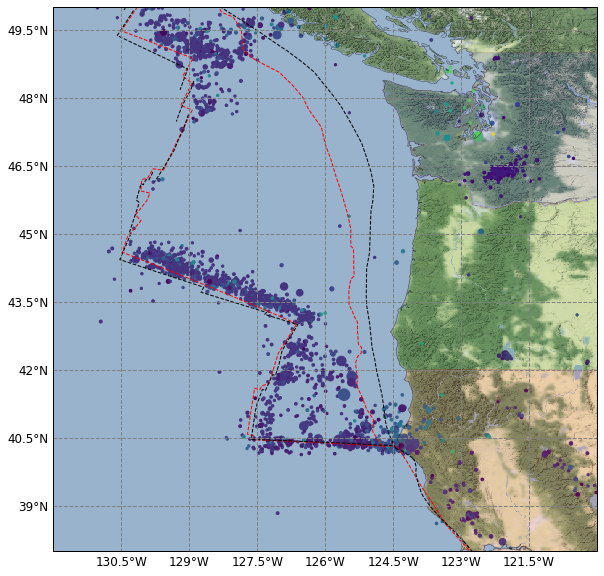

In [17]:
proj = ccrs.PlateCarree()

stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent([minlon, maxlon, \
               minlat, maxlat])

ax.coastlines(resolution='10m',linewidth=0.3)

# Add the Stamen data at zoom level 6.
ax.add_image(stamen_terrain,7,alpha=1)

#Add states
ax.add_geometries(california.geometry, crs=proj, facecolor='red', \
                  edgecolor='red', linestyle='--',alpha=0.1)
ax.add_geometries(oregon.geometry, crs=proj, facecolor='green', \
                  edgecolor='red', linestyle='--',alpha=0.1)
ax.add_geometries(washington.geometry, crs=proj, facecolor='blue', \
                  edgecolor='red', linestyle='--',alpha=0.1)

#Add the Bird (2002) plate boundaries - They plot in a strange location!
ax.add_geometries(boundaries.geometry, crs=proj, facecolor='None', \
                  edgecolor='red', linestyle='--')

#Add the USGS plate boundaries from https://www.sciencebase.gov/catalog/item/4f4e4a48e4b07f02db62303e
#They look slighly better, but still don't line up with the seismicity! 
ax.add_geometries(newplatebounds.geometry, crs=proj, facecolor='None', \
                  edgecolor='black', linestyle='--')


gl = ax.gridlines(crs=proj, draw_labels=True,
            linewidth=1, color='gray', alpha=1, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right= False 


eqs = ax.scatter(eventdetails['LON'],eventdetails['LAT'],s=scale_events(eventdetails['MAG']),c=eventdetails['DEP'],\
        transform=proj,alpha=1)
